<a href="https://colab.research.google.com/github/IlyaKo4atkov/OpenCV/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B0_%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%BE%D0%BC_%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D1%84%D0%B5%D0%B9%D1%81%D0%B5_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

## Разработал модель нейронной сети, которая предсказывает породу собак по загруженному изображению и выполнил деплой модели с использованием пользовательского интерфейса (UI) на основе библиотеки Gradio

In [ ]:
!pip install openai gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import keras
print(keras.__version__)

3.5.0


### Импорт необходимых библиотек

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0
from keras.applications import EfficientNetB0

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128


### Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

# Разархивируем датасета во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

#Фильтрация поврежденных изображений
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

--2024-11-23 18:03:34--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  14.2MB/s    in 54s     

2024-11-23 18:04:30 (13.6 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]

Удалено изображений: 10


In [ ]:
#Генерация датасета
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

#Определение меток датасета
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.
Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 

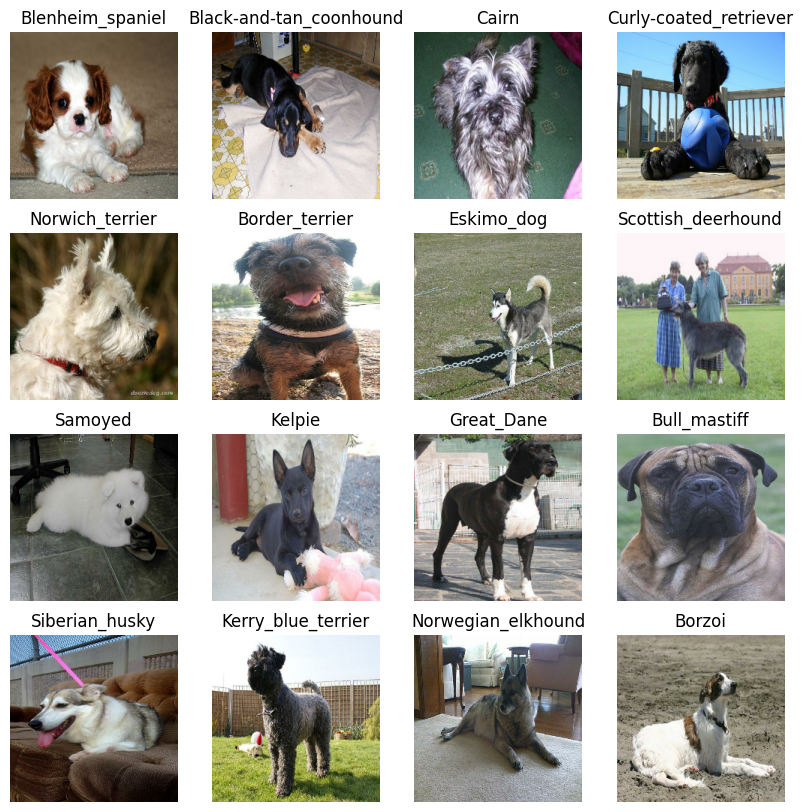

In [ ]:
#Проверка парвого батча
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2): # берем второй батч обучающей выборки
    for i in range(16): # отрисуем первые 16 картинок батча
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]]) # покажем метки
        plt.axis("off") # отключаем отображение осей

### Аугментация данных

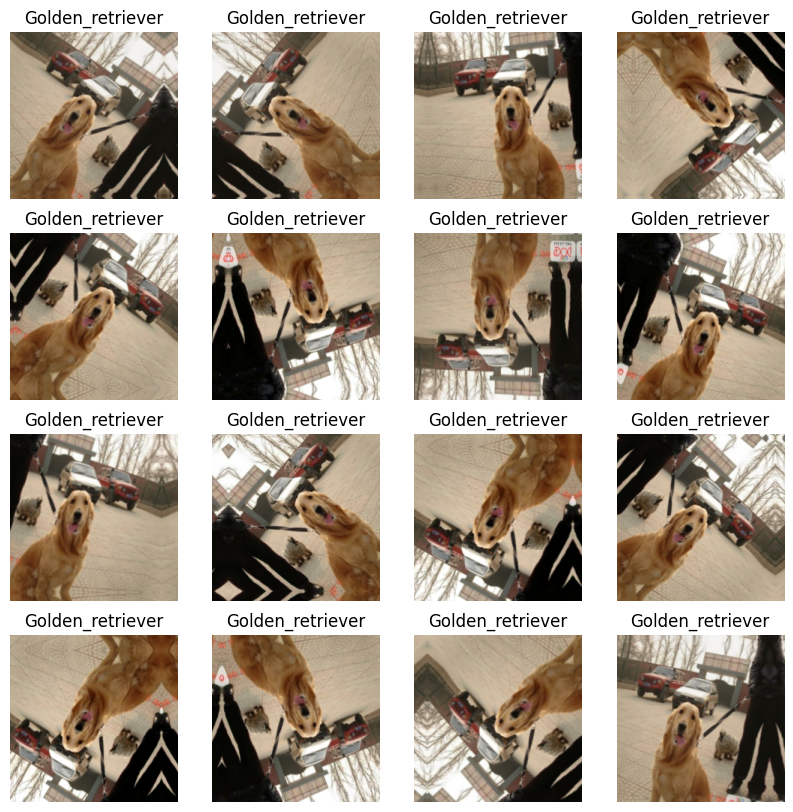

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images
#Вывод промежуточного результата
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8")) # Преобразуем картинку в тензор, теперь уже без NumPy
        plt.title("{}".format(CLASS_LIST[label[0]])) # Вывод метки
        plt.axis("off")

### Проведение предварительной обработки данных

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

### Перенос обучения с предварительно обученных весов

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - acc: 0.3872 - loss: 3.3508 - val_acc: 0.8055 - val_loss: 0.7324
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - acc: 0.5902 - loss: 1.6748 - val_acc: 0.8267 - val_loss: 0.5704
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - acc: 0.6369 - loss: 1.3216 - val_acc: 0.8330 - val_loss: 0.5211
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - acc: 0.6547 - loss: 1.2076 - val_acc: 0.8233 - val_loss: 0.5531
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - acc: 0.6701 - loss: 1.1714 - val_acc: 0.8320 - val_loss: 0.5355


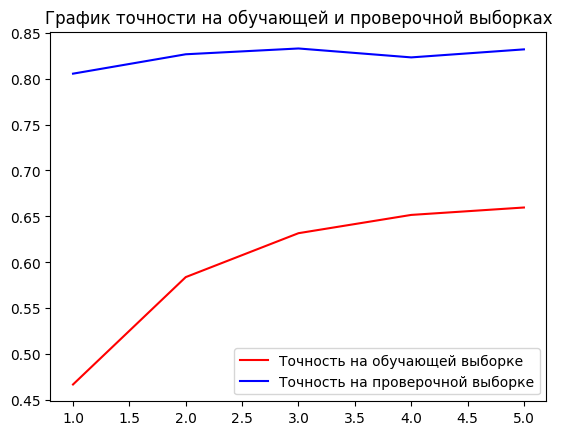

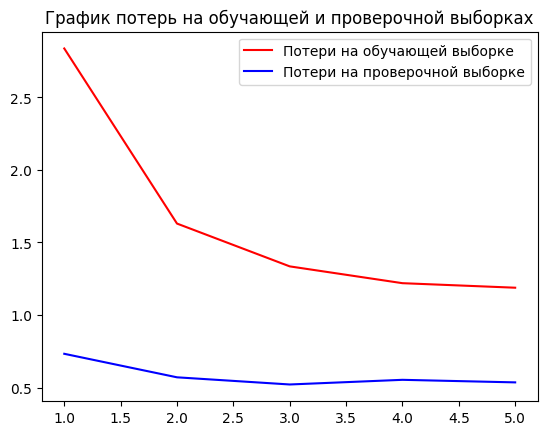

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)
show_plot(history)

### Деплой модели

In [ ]:
model.save('my_model.keras')

In [ ]:
!pip install --upgrade gradio

In [ ]:
import gradio as gr
import requests
from keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Загрузка модели
model = load_model('my_model.keras')
CLASS_LIST = ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Keeshond', 'Kelpie', 'Kerry_blue_terrier', 'Komondor', 'Kuvasz', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Malamute', 'Malinois', 'Maltese_dog', 'Mexican_hairless', 'Miniature_pinscher', 'Miniature_poodle', 'Miniature_schnauzer', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Otterhound', 'Papillon', 'Pekinese', 'Pembroke', 'Pomeranian', 'Pug', 'Redbone', 'Rhodesian_ridgeback', 'Rottweiler', 'Saint_Bernard', 'Saluki', 'Samoyed', 'Schipperke', 'Scotch_terrier', 'Scottish_deerhound', 'Sealyham_terrier', 'Shetland_sheepdog', 'Shih-Tzu', 'Siberian_husky', 'Silky_terrier', 'Soft-coated_wheaten_terrier', 'Staffordshire_bullterrier', 'Standard_poodle', 'Standard_schnauzer', 'Sussex_spaniel', 'Tibetan_mastiff', 'Tibetan_terrier', 'Toy_poodle', 'Toy_terrier', 'Vizsla', 'Walker_hound', 'Weimaraner', 'Welsh_springer_spaniel', 'West_Highland_white_terrier', 'Whippet', 'Wire-haired_fox_terrier', 'Yorkshire_terrier']  # Замените на ваши классы


In [ ]:
import json

#Сохранение истории в файле json
history_dict = history.history
with open('history.json', 'w') as f:
    json.dump(history_dict, f)

#Вывод промежуточных результатов
print(json.dumps(history_dict, indent=4))


{
    "acc": [
        0.46657752990722656,
        0.5836777091026306,
        0.6315629482269287,
        0.6514949202537537,
        0.6595770716667175
    ],
    "loss": [
        2.8356213569641113,
        1.6294925212860107,
        1.3346123695373535,
        1.218831181526184,
        1.1876466274261475
    ],
    "val_acc": [
        0.8055420517921448,
        0.8266893625259399,
        0.8330092430114746,
        0.8232863545417786,
        0.8320369720458984
    ],
    "val_loss": [
        0.7324262857437134,
        0.5704043507575989,
        0.52105712890625,
        0.5531231760978699,
        0.5355167388916016
    ]
}


### Создание интерфейса на Gradio

In [ ]:
# Определяем первую функцию для предсказания породы собаки
def predict_breed(image):
    IMAGE_SIZE = (224, 224)
    img = load_img(image, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = CLASS_LIST[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    return f"Предсказание: {predicted_class}\nВероятность: {confidence:.1f}%"

# Определяем вторую функцию для построения соответствующих графиков
def plot_history():
    # Загрузка истории из файла
    with open('history.json', 'r') as f:
        history_dict = json.load(f)

    # Построение графиков
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # График потерь
    ax[0].plot(history_dict['loss'], label='Потери на обучающей выборке')
    ax[0].plot(history_dict['val_loss'], label='Потери на валидационной выборке')
    ax[0].set_title('График потерь на обучающей и валидационной выборке')
    ax[0].set_xlabel('Эпоха')
    ax[0].set_ylabel('Потери')
    ax[0].legend()

    # График точности
    ax[1].plot(history_dict['acc'], label='Точность на обучающей выборке')
    ax[1].plot(history_dict['val_acc'], label='Точность на валидационной выборке')
    ax[1].set_title('График точности на обучающей и валидационной выборке')
    ax[1].set_xlabel('Эпоха')
    ax[1].set_ylabel('Точность')
    ax[1].legend()

    plt.tight_layout()
    return fig

# Создаем интерфейсы для каждой функции
interface1 = gr.Interface(
    fn=predict_breed,
    inputs=gr.Image(type="filepath"),
    outputs=gr.Textbox(),
    title="Предсказание породы собаки",
    description="Загрузите изображение собаки, чтобы получить предсказание породы."
)

interface2 = gr.Interface(
    fn=plot_history,
    inputs=[],
    outputs="plot",
    title="Графики процесса обучения модели нейронной сети"
)

# Объединяем интерфейсы в один с помощью вкладок
tabbed_interface = gr.TabbedInterface([interface1, interface2], ["Предсказание породы", "История обучения"])

# Запускаем интерфейс
tabbed_interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2057aaa34805eca683.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
